# Hannah Zhao - Week 2 DenseNet Model with MIL
## MIL (Multiple Instance Learning) stops you from punishing for “normal‐looking” patches in High-grade cases by moving supervision up to the case level
### Goal: incorporating the model I trained in simpledensenet_H&E_moreepochs.ipynb into the MIL
#### overall results:  
#### next step: 

In [1]:
# Standard library imports
import os
import re
import random
import shutil
from datetime import datetime
from collections import OrderedDict

# Data handling and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch and TorchVision libraries for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.models as models
from torchvision import transforms, datasets
from PIL import Image

# Scikit-Learn for evaluation metrics and data splitting
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Imbalanced-learn for oversampling to address class imbalance
from imblearn.over_sampling import RandomOverSampler

from torchvision import transforms
from torchvision.transforms import functional as F
from PIL import Image
from PIL import Image
from PIL import UnidentifiedImageError
from tqdm import tqdm


In [2]:
# Define local file paths

# Define your Desktop folder based on your OS; this uses the user's home directory.
desktop = os.path.join(os.path.expanduser("~"), "Desktop")

# Path to the filtered patches folder on your Desktop
filtered_patches_dir = os.path.join(desktop, "uni", "STAT 390", "Hannah Zhao", "CMIL_SP2025_Patches_Apr16")

# Path to the CSV file inside Desktop/uni/STAT 390/Hannah Zhao
csv_file_path = os.path.join(desktop, "uni", "STAT 390", "Hannah Zhao", "case_grade_match.csv")

# Directory to store model checkpoints
checkpoint_dir = os.path.join(desktop, "uni", "STAT 390", "Hannah Zhao", "Checkpoints")
os.makedirs(checkpoint_dir, exist_ok=True)  # Create the directory if it doesn't exist

# load labels 
labels = pd.read_csv(csv_file_path)

In [3]:
# === Helper: group patches
def group_patches(patch_dir):
    case_patches = {}
    for filename in os.listdir(patch_dir):
        match = re.search(r"case_(\d+)", filename)
        if match:
            case_num = int(match.group(1))
            if case_num not in case_patches:
                case_patches[case_num] = []
            case_patches[case_num].append(os.path.join(patch_dir, filename))
    return case_patches

patches = group_patches(filtered_patches_dir)

# Validation / Test transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Training transform (augmented)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [4]:
# Prepare case split
case_nums = list(patches.keys())
dataset = labels.loc[[(x-1) for x in case_nums]]  # Adjust indexing
valid_classes = [1.0, 3.0, 4.0]
filtered_dataset = dataset[dataset['Class'].isin(valid_classes)]

X = filtered_dataset.Case.reset_index(drop=True)
y = filtered_dataset.Class.reset_index(drop=True)


# All known cases
benign_cases = [2, 21, 22, 25, 34, 45, 53, 77, 78, 79, 85, 90]
highgrade_cases = [1, 3, 9, 12, 38, 49, 55, 60, 62, 70, 89, 92, 98, 99]

# Step 1: Manually assign known train/val cases (must exist in patches)
manual_train = [2, 3, 34, 9]     # 2 benign, 2 high-grade
manual_val   = [78, 92]          # 1 benign, 1 high-grade

# Step 2: Remove any missing cases
existing_case_ids = set(patches.keys())
train_cases = [c for c in manual_train if c in existing_case_ids]
val_cases   = [c for c in manual_val if c in existing_case_ids]

# Step 3: Assign remaining existing benign/high-grade cases to test set
used_cases = set(train_cases + val_cases)
remaining_benign = [c for c in benign_cases if c not in used_cases and c in existing_case_ids]
remaining_highgrade = [c for c in highgrade_cases if c not in used_cases and c in existing_case_ids]
test_cases = remaining_benign + remaining_highgrade

# Confirm distribution
print(f"Train cases: {train_cases}")
print(f"Val cases: {val_cases}")
print(f"Test cases: {test_cases}")


train_patches = {c: patches[c] for c in train_cases if c in patches}
val_patches   = {c: patches[c] for c in val_cases if c in patches}
test_patches  = {c: patches[c] for c in test_cases if c in patches}

# Optional: filter to just H&E stain
def filter_by_stain(d, keyword):
    out = {}
    for c, paths in d.items():
        f = [p for p in paths if keyword.lower() in os.path.basename(p).lower()]
        if f:
            out[c] = f
    return out

stain = "h&e"
train_patches = filter_by_stain(train_patches, stain)
val_patches = filter_by_stain(val_patches, stain)
test_patches = filter_by_stain(test_patches, stain)

Train cases: [2, 3, 34, 9]
Val cases: [78, 92]
Test cases: [21, 22, 77, 79, 85, 90, 1, 12, 89, 98, 99]


In [5]:
class MILDataset(Dataset):
    def __init__(self, case_patches, labels_df, transform=None, emergency_cap=800):
        self.transform = transform
        self.emergency_cap = emergency_cap  # only cap if massive
        self.bags, self.labels = [], []
        for case, paths in case_patches.items():
            raw = labels_df.loc[labels_df['Case'] == case, 'Class'].item()
            bag_lbl = 0 if raw == 1 else 1
            self.bags.append(paths)
            self.labels.append(bag_lbl)

    def __len__(self): return len(self.bags)

    def __getitem__(self, idx):
        paths = self.bags[idx]
        imgs = []
        for p in paths:
            try:
                img = Image.open(p).convert('RGB')
                if self.transform:
                    img = self.transform(img)
                imgs.append(img)
            except:
                continue

        if len(imgs) == 0:
            raise ValueError(f"No good patches in case {paths}")

        # Only sample if emergency_cap is set
        if self.emergency_cap is not None and len(imgs) > self.emergency_cap:
            imgs = random.sample(imgs, self.emergency_cap)

        return torch.stack(imgs), torch.tensor(self.labels[idx], dtype=torch.long)


class AttentionPool(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x, return_weights=False):
        weights = self.attention(x)     # (B, M, 1)
        weights = torch.softmax(weights, dim=1)
        weighted_x = (weights * x).sum(dim=1)  # (B, D)

        if return_weights:
            return weighted_x, weights.squeeze(-1)  # (B, D), (B, M)
        return weighted_x
    

# using Densenet to extract features at the patch-level, and adaptaive pooling for patch-level feature pooling
# the patch features are passed into Attentionpool which learns the weights across patches and combines them into a single bag label

class AttnMIL(nn.Module):
    def __init__(self, base_model, num_classes=2, embed_dim=512):
        super().__init__()
        self.features = base_model.features
        self.pool = nn.AdaptiveAvgPool2d((2,2))  # richer than (1,1)
        self.patch_projector = nn.Linear(base_model.classifier.in_features * 4, embed_dim)
        self.attention_pool = AttentionPool(embed_dim)
        self.classifier = nn.Linear(embed_dim, num_classes)
        
    def forward(self, x, return_patch_logits=False, return_attn_weights=False):
        if x.dim() == 4:
            x = x.unsqueeze(0)
        B, M, C, H, W = x.shape
        x = x.view(B*M, C, H, W)

        features = self.features(x)
        pooled = self.pool(features).view(B*M, -1)
        embedded = self.patch_projector(pooled).view(B, M, -1)

        if return_patch_logits:
            logits = self.classifier(embedded)  # (B, M, 2)
            return logits

        if return_attn_weights:
            bag_emb, attn_weights = self.attention_pool(embedded, return_weights=True)
            logits = self.classifier(bag_emb)
            return logits, attn_weights  # bag prediction + per-patch attention scores

        bag_emb = self.attention_pool(embedded)
        logits = self.classifier(bag_emb)
        return logits


In [6]:
# Set up datasets
train_ds = MILDataset(train_patches, labels, transform=train_transform)
val_ds   = MILDataset(val_patches,   labels, transform=transform)
test_ds  = MILDataset(test_patches,  labels, transform=transform, emergency_cap=None)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=1, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=1, shuffle=False)

In [7]:
def save_checkpoint(model, arch, checkpoint_dir, optimizer, epoch):
    os.makedirs(checkpoint_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{checkpoint_dir}/{timestamp}_{arch}_epoch{epoch}.pth"
    checkpoint = {
        "arch": arch,
        "model_state_dict": model.state_dict(),
        "epoch": epoch,
        "optimizer_state_dict": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)
    print(f"✅ Checkpoint saved: {filename}")

def validation(model, criterion, val_loader):
    val_loss = 0
    correct_total = 0
    sample_total = 0
    model.eval()
    with torch.no_grad():
        for bags, labels in val_loader:
            bags = bags.to(device)
            labels = labels.to(device)
            outputs = model(bags)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct_total += (preds == labels).sum().item()
            sample_total += labels.size(0)
    return val_loss / sample_total, correct_total / sample_total

def train_model(model, optimizer, criterion, train_loader, val_loader, arch, checkpoint_dir, epochs=5):
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for bags, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            bags = bags.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(bags)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        val_loss, val_acc = validation(model, criterion, val_loader)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {running_loss/len(train_loader):.3f}, Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.3f}")
        save_checkpoint(model, arch, checkpoint_dir, optimizer, epoch+1)
    return model

In [8]:
# ------------------- Load pretrained patch model -------------------
class PatchClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        self.features = base.features
        self.pool = nn.AdaptiveAvgPool2d((2,2))
        self.classifier = nn.Linear(base.classifier.in_features * 4, 2)

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x).view(x.size(0), -1)
        return self.classifier(x)

patch_model = PatchClassifier()
patch_model.load_state_dict(torch.load(os.path.join(checkpoint_dir, "patch_classifier.pth")))
patch_model.eval()

PatchClassifier(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ------------------- Inject backbone into MIL -------------------
base_model = models.densenet121(weights=None)
base_model.features = patch_model.features

model = AttnMIL(base_model=base_model).to(device)
for param in model.features.parameters():
    param.requires_grad = False

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
arch = "densenet121_simplemil"


train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)


In [10]:
# Train model
trained_model = train_model(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    arch=arch,
    checkpoint_dir=checkpoint_dir,
    epochs=5,
)

Epoch 1/5: 100%|██████████| 4/4 [02:34<00:00, 38.52s/it]


Epoch 1/5, Train Loss: 12.368, Val Loss: 8.198, Val Acc: 0.500
✅ Checkpoint saved: /Users/hannahzhao/Desktop/uni/STAT 390/Hannah Zhao/Checkpoints/20250504_234233_densenet121_simplemil_epoch1.pth


Epoch 2/5: 100%|██████████| 4/4 [00:49<00:00, 12.43s/it]


Epoch 2/5, Train Loss: 6.385, Val Loss: 2.012, Val Acc: 0.500
✅ Checkpoint saved: /Users/hannahzhao/Desktop/uni/STAT 390/Hannah Zhao/Checkpoints/20250504_234411_densenet121_simplemil_epoch2.pth


Epoch 3/5: 100%|██████████| 4/4 [00:49<00:00, 12.45s/it]


Epoch 3/5, Train Loss: 2.493, Val Loss: 1.018, Val Acc: 0.500
✅ Checkpoint saved: /Users/hannahzhao/Desktop/uni/STAT 390/Hannah Zhao/Checkpoints/20250504_234549_densenet121_simplemil_epoch3.pth


Epoch 4/5: 100%|██████████| 4/4 [00:49<00:00, 12.48s/it]


Epoch 4/5, Train Loss: 0.454, Val Loss: 0.005, Val Acc: 1.000
✅ Checkpoint saved: /Users/hannahzhao/Desktop/uni/STAT 390/Hannah Zhao/Checkpoints/20250504_234727_densenet121_simplemil_epoch4.pth


Epoch 5/5: 100%|██████████| 4/4 [01:01<00:00, 15.31s/it]


Epoch 5/5, Train Loss: 1.978, Val Loss: 0.000, Val Acc: 1.000
✅ Checkpoint saved: /Users/hannahzhao/Desktop/uni/STAT 390/Hannah Zhao/Checkpoints/20250504_234918_densenet121_simplemil_epoch5.pth


=== Case-Level Classification Report ===
                 precision    recall  f1-score   support

         Benign       0.60      0.75      0.67         4
High-grade CMIL       0.75      0.60      0.67         5

       accuracy                           0.67         9
      macro avg       0.68      0.68      0.67         9
   weighted avg       0.68      0.67      0.67         9


=== Patch-Level Classification Report (weak labels) ===
                 precision    recall  f1-score   support

         Benign       0.55      0.95      0.70       621
High-grade CMIL       0.75      0.15      0.24       565

       accuracy                           0.57      1186
      macro avg       0.65      0.55      0.47      1186
   weighted avg       0.64      0.57      0.48      1186



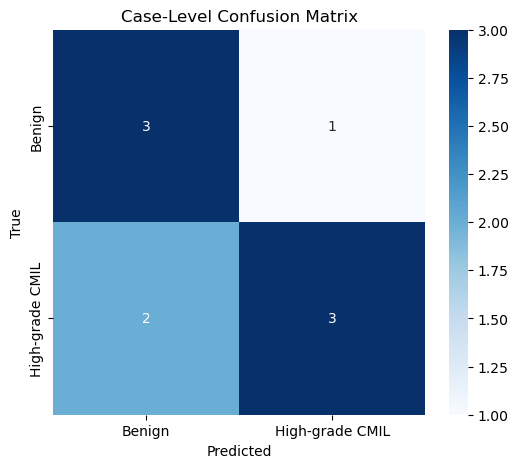

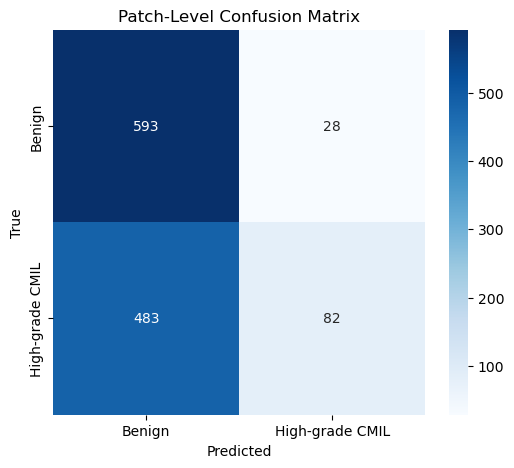

In [11]:
# ------------------- Evaluation -------------------
model.eval()
all_preds, all_trues = [], []
all_patch_preds, all_patch_trues = [], []

with torch.no_grad():
    for X_bag, y in test_loader:
        X_bag, y = X_bag.to(device), y.to(device)

        # Case-level prediction
        bag_logits = model(X_bag)
        bag_pred = bag_logits.argmax(dim=1)
        all_preds.extend(bag_pred.cpu().numpy())
        all_trues.extend(y.cpu().numpy())

        # Patch-level prediction (weak supervision)
        patch_logits = model(X_bag, return_patch_logits=True)
        patch_pred = patch_logits.argmax(dim=2).squeeze(0).cpu().numpy()
        patch_labels = y.cpu().item() * np.ones_like(patch_pred)

        all_patch_preds.extend(patch_pred)
        all_patch_trues.extend(patch_labels)

# Reports
print("=== Case-Level Classification Report ===")
print(classification_report(all_trues, all_preds, target_names=['Benign', 'High-grade CMIL'], labels=[0,1]))

print("\n=== Patch-Level Classification Report (weak labels) ===")
print(classification_report(all_patch_trues, all_patch_preds, target_names=['Benign', 'High-grade CMIL'], labels=[0,1]))

# Confusion matrices
for name, preds, trues in [
    ("Case-Level", all_preds, all_trues),
    ("Patch-Level", all_patch_preds, all_patch_trues)
]:
    cm = confusion_matrix(trues, preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Benign','High-grade CMIL'],
                yticklabels=['Benign','High-grade CMIL'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{name} Confusion Matrix")
    plt.show()